<a href="https://colab.research.google.com/github/jborders23/math6397-funhouse/blob/main/MATH6397_Final_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data, Generate Features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#load data from GitHub
tesla = pd.read_csv("https://raw.githubusercontent.com/jborders23/math6397-funhouse/master/TSLA.csv")
ford = pd.read_csv("https://raw.githubusercontent.com/jborders23/math6397-funhouse/master/F.csv")
gm = pd.read_csv("https://raw.githubusercontent.com/jborders23/math6397-funhouse/master/GM.csv")
sp500 = pd.read_excel("https://raw.githubusercontent.com/jborders23/math6397-funhouse/master/SP500.xlsx")
#reverse sp500 and reset index
sp500 = sp500.iloc[::-1].reset_index(drop=True)

In [ ]:
#generate some features for Tesla
tesla['Open-Close'] = (tesla.Open - tesla.Close)/tesla.Open
tesla['High-Low'] = (tesla.High - tesla.Low)/tesla.Low
tesla['percent_change'] = tesla['Adj Close'].pct_change()
tesla['std_5'] = tesla['percent_change'].rolling(5).std()
tesla['return_5'] = tesla['percent_change'].rolling(5).mean()
tesla.dropna(inplace=True)

In [ ]:
#keep date & closing price for all non-Tesla securities
f = ford.iloc[:,[0,4]]
g = gm.iloc[:,[0,4]]
s = sp500.iloc[:,[0,4]]

#keep tesla's extra features & 'tomorrow' price
t = tesla.iloc[:,[0,4,7,8,9,10,11,12]]
#add column to tesla that equals 1 if tomorrow>close
t['Movement'] = np.where(t['Tomorrow'] > t['Close'],1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
#concatenate dfs (drop Tesla's tomorrow price)
data = pd.concat(objs=[f['Date'],s['Close'],f['Close'],g['Close'],t['Close'],
                       t['Open-Close'],t['High-Low'],t['percent_change'],t['std_5'],t['return_5'],t['Movement']]
                 ,axis=1,keys=['Date','SP','Ford','GM','Tesla','Open-Close','High-Low','Pct Change','std_5','return_5','Movement'])
#normalize the time series: xi - min(xi)/max(xi) - min(xi)
s_data = data #will work with a standardized data frame
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s_data[['SP','Ford','GM','Tesla','Open-Close','High-Low','Pct Change','std_5','return_5']] = scaler.fit_transform(s_data[['SP',
                                        'Ford','GM','Tesla','Open-Close','High-Low','Pct Change','std_5','return_5']])
s_data.dropna(inplace=True)
s_data.head()

,Date,SP,Ford,GM,Tesla,Open-Close,High-Low,Pct Change,std_5,return_5,Movement
10,5/10/2016,0.038377,0.940476,0.322331,0.007015,0.573942,0.050404,0.511570,0.168494,0.416075,1.0
11,5/11/2016,0.029255,0.923611,0.316349,0.007079,0.569772,0.145547,0.517417,0.158002,0.459388,0.0
12,5/12/2016,0.029095,0.926587,0.318564,0.006682,0.668779,0.119994,0.494629,0.087628,0.500916,1.0
13,5/13/2016,0.021085,0.913690,0.303943,0.006760,0.597723,0.050268,0.518145,0.062588,0.486431,1.0
14,5/16/2016,0.030262,0.923611,0.307266,0.006921,0.592106,0.063702,0.522255,0.007339,0.517675,0.0


In [ ]:
# split s_data into what the network needs
df = s_data.iloc[:,1:10]
labels = s_data.iloc[:,-1]

,SP,Ford,GM,Tesla,Open-Close,High-Low,Pct Change,std_5,return_5
10,0.038377,0.940476,0.322331,0.007015,0.573942,0.050404,0.511570,0.168494,0.416075
11,0.029255,0.923611,0.316349,0.007079,0.569772,0.145547,0.517417,0.158002,0.459388
12,0.029095,0.926587,0.318564,0.006682,0.668779,0.119994,0.494629,0.087628,0.500916
13,0.021085,0.913690,0.303943,0.006760,0.597723,0.050268,0.518145,0.062588,0.486431
14,0.030262,0.923611,0.307266,0.006921,0.592106,0.063702,0.522255,0.007339,0.517675


# Specifying RF Model

In [ ]:
#train/test split (first 80:last 20)
splitter = int(len(s_data) * 0.8)
train = s_data.iloc[0:splitter,1:10] #length 997
train_labels = s_data.iloc[0:splitter,-1]
test = s_data.iloc[splitter:,1:10] #length 250
test_labels = s_data.iloc[splitter:,-1]

Most of this taken from: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

and https://blog.quantinsti.com/random-forest-algorithm-in-python/

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RSEED = 50

# Features for feature importances
features = list(train.columns)

# Create the model with x trees
model = RandomForestClassifier(n_estimators=150, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [ ]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

Average number of nodes 399
Average maximum depth 21


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.0s finished


# Results

Recall Baseline: 1.0 Test: 0.28 Train: 1.0
Precision Baseline: 0.56 Test: 0.66 Train: 1.0
Roc Baseline: 0.5 Test: 0.52 Train: 1.0


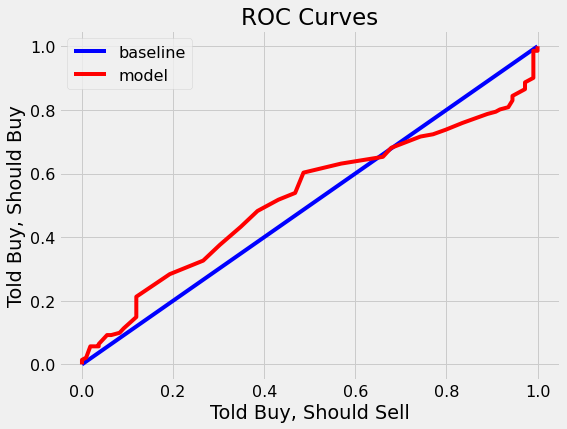

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('Told Buy, Should Sell'); 
    plt.ylabel('Told Buy, Should Buy'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Normalized confusion matrix
[[0.80733945 0.19266055]
 [0.71631206 0.28368794]]


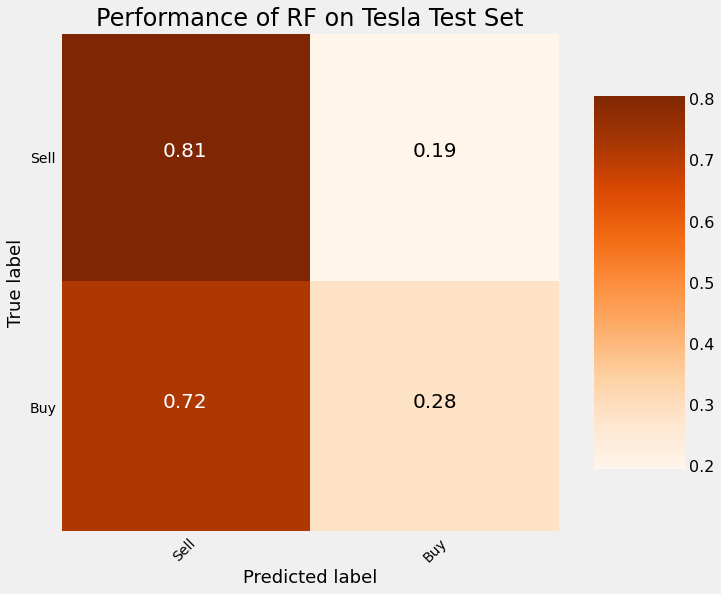

In [ ]:

#plt.savefig('roc_auc_curve.png')

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Sell', 'Buy'],
                      title = 'Performance of RF on Tesla Test Set',normalize=True)

#plt.savefig('cm.png')

In [ ]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
print(fi)

      feature  importance
7       std_5    0.114173
3       Tesla    0.113432
6  Pct Change    0.113298
2          GM    0.113150
0          SP    0.112347
8    return_5    0.111033
4  Open-Close    0.108627
5    High-Low    0.107091
1        Ford    0.106849
